Pierre Nikitits
## Course Project: Electricity Price Explanation

Dataset:

- Consumption
- Exchange
- Net Export/Import
- Energy Sources
- Residual Load
- Weather Conditions
- Market Dynamics

Steps:

1. Preprocessing Data
2. Metric definition
3. Define models: Random Forest, Linear Regression, SVR, XGboost
4. Hyperparameter Tuning: Optuna search
5. Evaluation
6. Interpretation


## Loading and Preprocessing the data

In [1]:
import pandas as pd
path = "/Users/pierre/Documents/GitHub/EnsembleLearningProject/Data/"

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID')
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

In [2]:
print("X_train :" , X_train.shape)
print("y_train :" , y_train.shape)

print("\nX_test  :" , X_test.shape)
print("y_test  :" , y_test.shape)

X_train : (1494, 34)
y_train : (1494, 1)

X_test  : (654, 34)
y_test  : (654, 1)


In [3]:
X_train.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)
X_test.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)

In [4]:
X_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1054,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
2049,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
1924,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
297,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
1101,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,0.238693,-0.240862,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [5]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [6]:
print(X_train.shape)
print(y_train.shape)

(1276, 32)
(1276, 1)


## Metrics
- Mean Squared Error
- Root Mean Squared Error
- Mean Absolute Error
- R-squared
- Mean Absolute Percentage Error


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , mean_absolute_percentage_error , log_loss
from math import sqrt

def find_metrics(y_test_values , predicted_values):
    mse = mean_squared_error(y_test_values, predicted_values)
    print("Mean Squared Error:", mse)

    rmse = sqrt(mean_squared_error(y_test_values, predicted_values))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    mae = mean_absolute_error(y_test_values, predicted_values)
    print(f"Mean Absolute Error (MAE): {mae}")

    r2 = r2_score(y_test_values, predicted_values)
    print(f"R-squared (R²): {r2}")

    mape = mean_absolute_percentage_error(y_test_values, predicted_values)
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

    # loss1 = log_loss(y_test_values , predicted_values)
    # print(f"log loss: {loss1}")



## Predicting the missing values

### Using KNN Imputer & Simple Imputer

In [58]:


X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID').loc[X_train.index]
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID').loc[X_test.index]

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

param_grid = {
    'simpleimputer': [SimpleImputer(strategy='mean'), KNNImputer(), SimpleImputer(strategy='median')],
    'randomforestregressor__n_estimators': [942],
    'randomforestregressor__max_depth': [2],
    'randomforestregressor__min_samples_split': [11]
}

pipeline = make_pipeline(SimpleImputer(),
                         RandomForestRegressor(random_state=42))
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_split': 11, 'randomforestregressor__n_estimators': 942, 'simpleimputer': SimpleImputer()}
Best Score: -1.0716437046385983


### Comparison with baseline

In [177]:

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID']).dropna()
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID').loc[X_train.index]
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID']).dropna()
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID').loc[X_test.index]

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

param_grid = {
    'randomforestregressor__n_estimators': [942],
    'randomforestregressor__max_depth': [2],
    'randomforestregressor__min_samples_split': [11]
}

pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         RandomForestRegressor(random_state=42))
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)
y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))

Best Parameters: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_split': 11, 'randomforestregressor__n_estimators': 942}
Best Score: -1.1480085320095987


,TARGET,Predicted
TARGET,1.000000,-0.042247
Predicted,-0.042247,1.000000


The performance is lower with the NANs dropped

## How impactful is n_estimators vs score

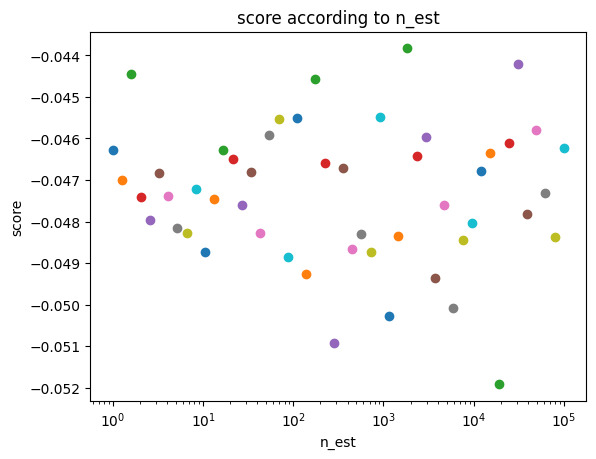

In [49]:
import matplotlib.pyplot as plt

n_ests = np.logspace(0, 5, 50)
forest =    make_pipeline(KNNImputer(), RandomForestRegressor(n_estimators=500, max_depth=3, min_samples_split=10))

for n_est in n_ests:
    forest.n_estimators = n_est
    forest.fit(X_train, y_train.values.ravel())
    forest_score = forest.score(X_test, y_test)
    plt.scatter(n_est, forest_score)
plt.xscale("log")
plt.xlabel("n_est")
plt.ylabel("score")
plt.title("score according to n_est")
plt.show()

We don't see a strong tendancy between n_est and score

## One model per country

In [176]:
X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['DAY_ID'])
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

for country in ["FR", "DE", ["FR", "DE"]]:
    print(f"Testing for country {country}")
    if not isinstance(country, list):
        X_train_country = X_train[X_train["COUNTRY"] == country].drop(columns=["COUNTRY"])
        X_test_country = X_test[X_test["COUNTRY"] == country].drop(columns=["COUNTRY"])
    else:
        X_train_country = X_train.drop(columns=["COUNTRY"])
        X_test_country = X_test.drop(columns=["COUNTRY"])
        
    y_test_country = y_test.loc[X_test_country.index]
    y_train_country = y_train.loc[X_train_country.index]
    
    param_grid = {
        'simpleimputer': [SimpleImputer(strategy='mean'), KNNImputer()],
        'randomforestregressor__n_estimators': [942],
        'randomforestregressor__max_depth': [2],
        'randomforestregressor__min_samples_split': [11]
    }
    pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                             RandomForestRegressor(random_state=42))
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
    grid_search.fit(X_train_country, y_train_country.values.ravel())

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    print("Best Score:", grid_search.best_score_)
    
    y_test_country["Predicted"] = grid_search.predict(X_test_country)
    display(y_test_country.corr("spearman"))

Testing for country FR
Best Parameters: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_split': 11, 'randomforestregressor__n_estimators': 942, 'simpleimputer': KNNImputer()}
Best Score: -1.0882895788914249


,TARGET,Predicted
TARGET,1.000000,-0.059489
Predicted,-0.059489,1.000000


Testing for country DE
Best Parameters: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_split': 11, 'randomforestregressor__n_estimators': 942, 'simpleimputer': KNNImputer()}
Best Score: -1.051616540249641


,TARGET,Predicted
TARGET,1.000000,-0.038399
Predicted,-0.038399,1.000000


Testing for country ['FR', 'DE']
Best Parameters: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_split': 11, 'randomforestregressor__n_estimators': 942, 'simpleimputer': SimpleImputer()}
Best Score: -1.0716437046385983


,TARGET,Predicted
TARGET,1.000000,-0.015936
Predicted,-0.015936,1.000000


If we consider 50% DE and 50% FR data, there is no difference in average between 2 models and 1 unique model.

## Processing data in a time series fashion

Since the data are shuffled and test data can be in the middle of some training days, we can't use recursive forecasting, and we will have to stick to day to day forecasting.

<AxesSubplot: xlabel='DAY_ID', ylabel='TARGET'>

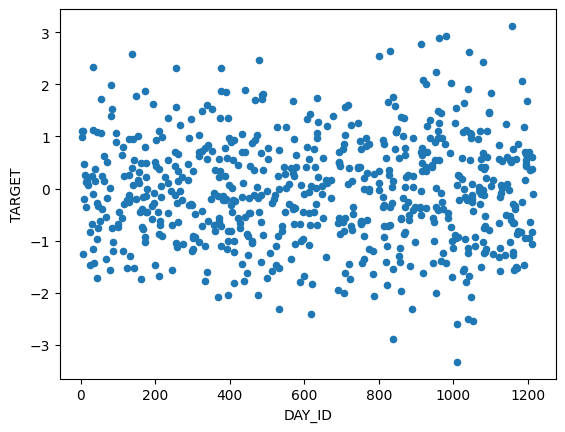

In [14]:
days = pd.read_csv(path + 'X_test.csv').set_index('ID')
pd.merge(days, y_test, left_index=True, right_index=True).plot.scatter(x="DAY_ID", y="TARGET")

We do not see obvious seasonality in this data, but we can still try it.

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
import datetime

# Standardize the date
def convert_to_date(x):
    return datetime.date(2000,1,1)+datetime.timedelta(days=x)

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID')#.drop(columns=['ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID')#.drop(columns=['ID'])
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

for country in ["FR", "DE"]:
    print(f"Testing for country {country}")
    X_train_country = X_train[X_train["COUNTRY"] == country].drop(columns=["COUNTRY"]).dropna()
    X_test_country = X_test[X_test["COUNTRY"] == country].drop(columns=["COUNTRY"]).dropna()
    
    y_test_country = y_test.loc[X_test_country.index]
    y_train_country = y_train.loc[X_train_country.index]
    
    data_train_country = pd.merge(X_train_country, y_train_country, left_index=True, right_index=True)
    data_test_country = pd.merge(X_test_country, y_test_country, left_index=True, right_index=True)
    
    data_train_country['DAY_ID'] = data_train_country['DAY_ID'].apply(convert_to_date)
    data_test_country['DAY_ID'] = data_test_country['DAY_ID'].apply(convert_to_date)
    
    data_train_country = data_train_country.reset_index(drop=True).set_index("DAY_ID").sort_index().reset_index(drop=True)
    data_test_country = data_test_country.reset_index(drop=True).set_index("DAY_ID").sort_index().reset_index(drop=True)
    
    steps = data_test_country.shape[0] - 1
    
    forecaster = ForecasterAutoregDirect(
        regressor = RandomForestRegressor(random_state=42),
        steps=steps,
        lags=15,
             )
    forecaster.fit(
        y    = data_train_country['TARGET'],
        exog = data_train_country[[col for col in data_train_country if col != 'TARGET']]
    )
    
    # Predicting leads to a crash that we couldn't fix, we could not assess the performance of the model. :(.
    
#     predictions = forecaster.predict(
#                   steps = steps,
#                   exog = data_test_country[[col for col in data_test_country if col != 'TARGET']]
#               )
    
#     error_mse = mean_squared_error(
#                 y_true = data_test_country['TARGET'],
#                 y_pred = predictions
#             )
    
#     print(f"Test error (mse): {error_mse}")

/home/felix/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing for country FR
Testing for country DE


## Feature engineering

We will try to avoid correlation and dependancy by selecting features.

### RFE

In [173]:
from sklearn.feature_selection import RFE

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

# Replaced with the optimal params computed with optuna tuning
param_grid = {
    'simpleimputer': [KNNImputer()],
    'rfe__estimator__n_estimators': [942],
    'rfe__estimator__max_depth': [2],
    'rfe__estimator__min_samples_split': [11]
}

pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         RFE(RandomForestRegressor(random_state=42)),
                         )

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))

Best Parameters: {'rfe__estimator__max_depth': 2, 'rfe__estimator__min_samples_split': 11, 'rfe__estimator__n_estimators': 942, 'simpleimputer': KNNImputer()}
Best Score: -1.0720844540438828


,TARGET,Predicted
TARGET,1.000000,-0.020675
Predicted,-0.020675,1.000000


In [97]:
post_rfe_cols = X_train.columns[grid_search.best_estimator_['rfe'].support_]
post_rfe_cols

Index(['DE_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_GAS', 'FR_COAL', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'DE_WIND',
       'GAS_RET', 'CARBON_RET'],
      dtype='object')

Visualization of the RFE result in correlation

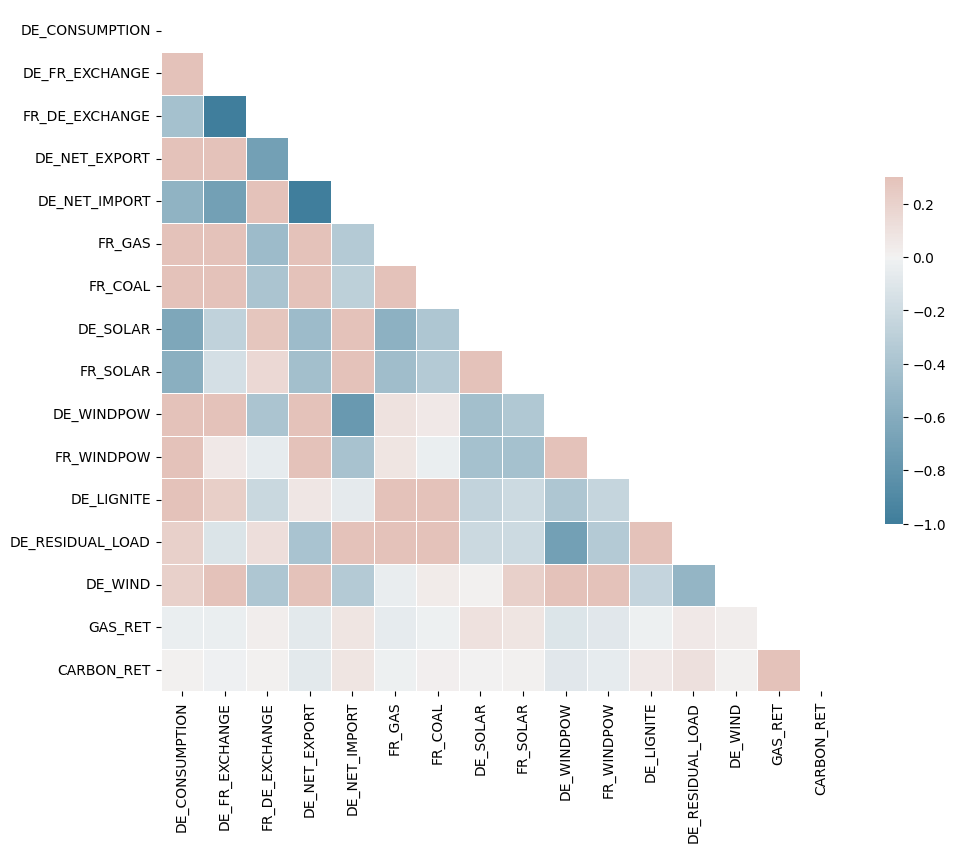

In [48]:
import seaborn as sns
corr = X_train[X_train.columns[grid_search.best_estimator_['rfe'].support_]].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("rfe_corr.svg", format="svg")

There are still correlated features selected over non correlated, lower interest with respect to MSE.

### PCA + RFE

In [172]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

# Replaced with the optimal params computed with optuna tuning
param_grid = {
    'simpleimputer': [SimpleImputer(strategy='mean'), KNNImputer()],
    'rfe__estimator__n_estimators': [942],
    'rfe__estimator__max_depth': [2],
    'rfe__estimator__min_samples_split': [11]
}

pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         PCA(0.8),
                         RFE(RandomForestRegressor(random_state=42)),
                         )

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))

Best Parameters: {'rfe__estimator__max_depth': 2, 'rfe__estimator__min_samples_split': 11, 'rfe__estimator__n_estimators': 942, 'simpleimputer': KNNImputer()}
Best Score: -1.0724808631593516


,TARGET,Predicted
TARGET,1.000000,-0.005856
Predicted,-0.005856,1.000000


### Removing correlated features

In [ ]:
# pip install feature-engine

In [171]:
from feature_engine.selection import SmartCorrelatedSelection

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')


param_grid = {
    'simpleimputer': [SimpleImputer(strategy='mean'), KNNImputer()],
    'rfe__estimator__n_estimators': [942],
    'rfe__estimator__max_depth': [2],
    'rfe__estimator__min_samples_split': [11]
}


pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         SmartCorrelatedSelection(
                            variables=None,
                            method="pearson",
                            threshold=0.8,
                            missing_values="raise",
                            selection_method="variance",
                            estimator=None),
                         RFE(RandomForestRegressor(random_state=42)),
                         )



grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))

Best Parameters: {'rfe__estimator__max_depth': 2, 'rfe__estimator__min_samples_split': 11, 'rfe__estimator__n_estimators': 942, 'simpleimputer': KNNImputer()}
Best Score: -1.071733821787976


,TARGET,Predicted
TARGET,1.000000,-0.012283
Predicted,-0.012283,1.000000


In [100]:
# grid_search.best_estimator_["smartcorrelatedselection"].feature_names_in_ = X_train.columns
grid_search.best_estimator_["smartcorrelatedselection"].features_to_drop_

['x0', 'x2', 'x6', 'x7', 'x16', 'x26']

In [101]:
scs_filtered_cols = [int(feature[1:]) for feature in grid_search.best_estimator_["smartcorrelatedselection"].features_to_drop_]

In [93]:
post_scs_cols = X_train.columns[[i for i in range(len(X_train.columns)) if i not in scs_filtered_cols]]
post_rfe = post_scs_cols[grid_search.best_estimator_['rfe'].support_]
print([col for col in X_train.columns if col not in post_rfe])

['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'FR_HYDRO', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'COAL_RET']


## Models Definitions

1. Random Forest
2. Linear Regression
3. SVR
4. XGboost
5. Ensemble Voting
6. Decision Tree

## 1. Random Forest

In [8]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape_error
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)



def objective_rand_forest(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 11)

    
    random_forest = RandomForestRegressor(
        random_state=11,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    
    random_forest.fit(X_train, y_train.values.ravel())
    pred = random_forest.predict(X_test)

    
    error = mape_error(y_test, pred)

    trial.report(error, step=0)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return error


pruner = optuna.pruners.MedianPruner()


study_rand_forest = optuna.create_study(direction='minimize',
                            pruner=pruner,
                            study_name="example_study_with_pruning",
                            storage='sqlite:///example_study_with_pruning.db',
                            load_if_exists=True)

study_rand_forest.optimize(objective_rand_forest, n_trials=100 , n_jobs=-1)


In [9]:
print(f"Best trial: {study_rand_forest.best_trial}")
print(f"Best parameters: {study_rand_forest.best_params}")
print(f"Best value (accuracy): {study_rand_forest.best_value}")

Best trial: FrozenTrial(number=180, state=1, values=[2.353829842501579], datetime_start=datetime.datetime(2024, 3, 4, 15, 27, 37, 385801), datetime_complete=datetime.datetime(2024, 3, 4, 15, 27, 41, 819163), params={'n_estimators': 322, 'max_depth': 2, 'min_samples_split': 11}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.353829842501579}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=1), 'max_depth': IntDistribution(high=11, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=11, log=False, low=4, step=1)}, trial_id=181, value=None)
Best parameters: {'n_estimators': 322, 'max_depth': 2, 'min_samples_split': 11}
Best value (accuracy): 2.353829842501579


In [10]:
random_forest = RandomForestRegressor(random_state=42 , n_estimators=323 , max_depth=2 , min_samples_split=10)
random_forest.fit(X_train, y_train.values.ravel())

random_forest_pred = random_forest.predict(X_test)
find_metrics(y_test['TARGET'].values , random_forest_pred)

Mean Squared Error: 1.104491606844341
Root Mean Squared Error (RMSE): 1.050947956296762
Mean Absolute Error (MAE): 0.8460797895221016
R-squared (R²): -0.051758170734791165
Mean Absolute Percentage Error (MAPE): 2.4003542132188103%


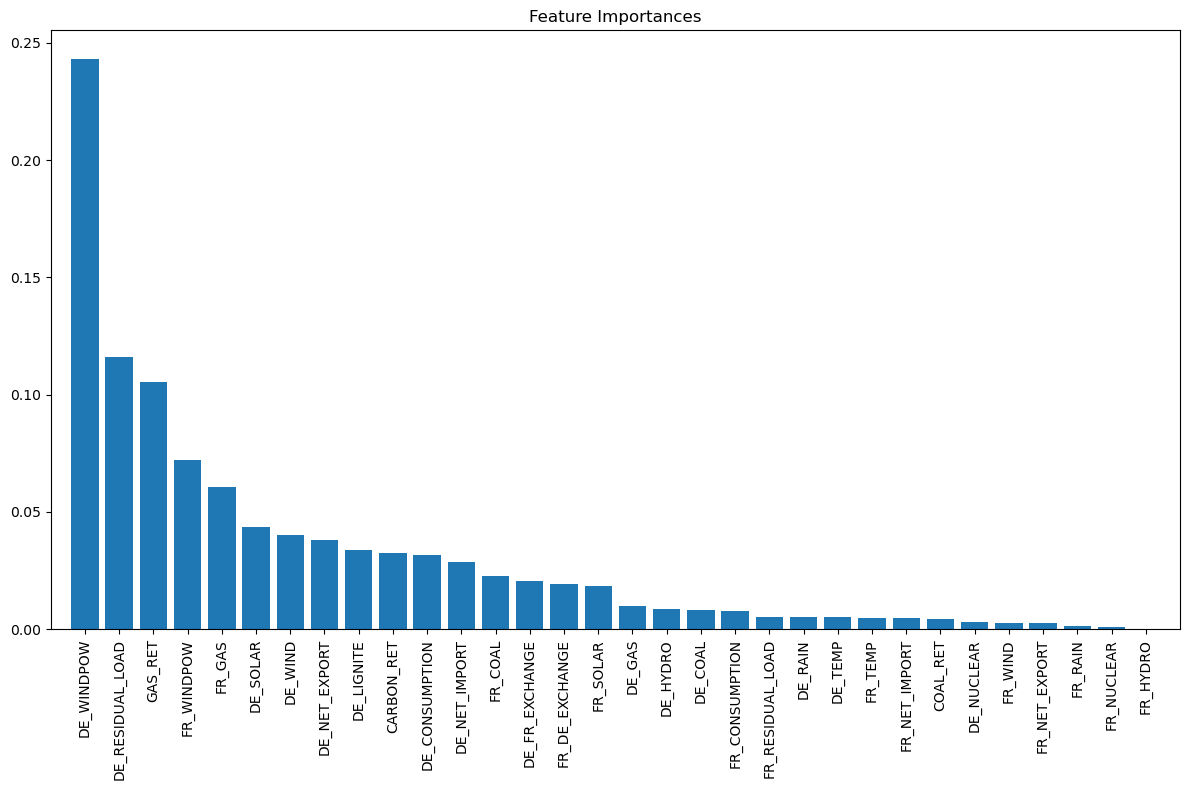

In [11]:
import numpy as np
import matplotlib.pyplot as plt


feature_importances = random_forest.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]


plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()

## 2. Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train.values.ravel())

linear_pred = linear_regression.predict(X_test)
find_metrics(y_test , linear_pred)

Mean Squared Error: 1.1518256780029095
Root Mean Squared Error (RMSE): 1.0732314186618417
Mean Absolute Error (MAE): 0.8674191694960335
R-squared (R²): -0.09683229876497612
Mean Absolute Percentage Error (MAPE): 2.7917000979889517%


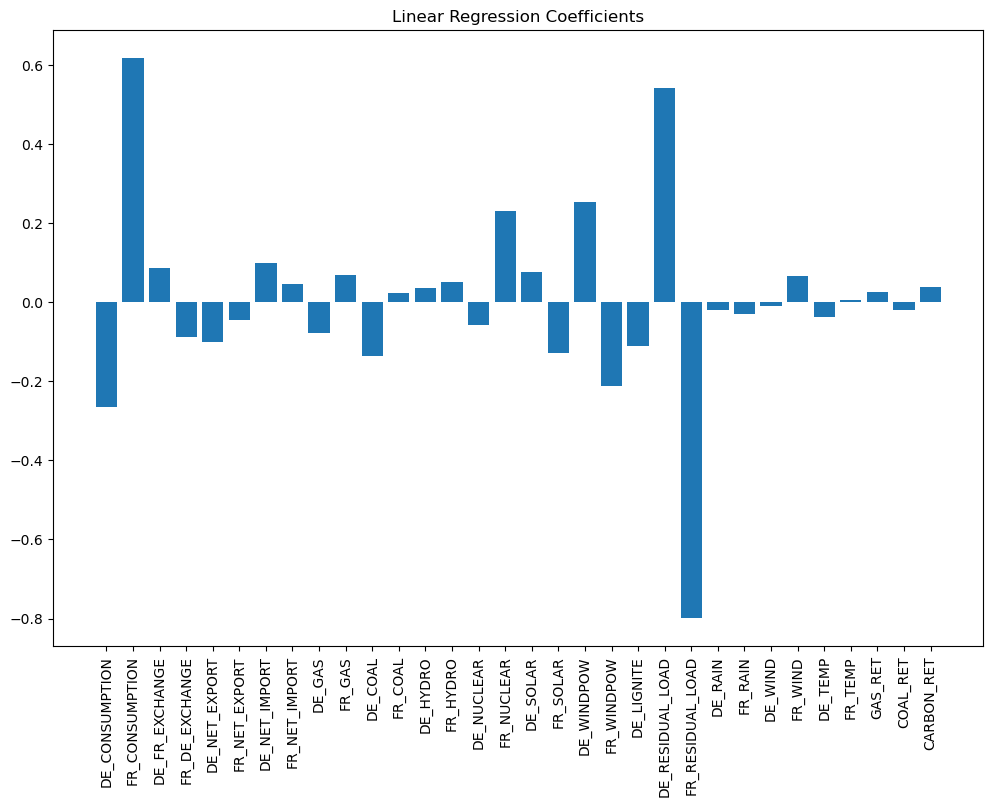

In [13]:
coefficients = linear_regression.coef_
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("Linear Regression Coefficients")
plt.show()


## 3. SVR

In [14]:
from sklearn.svm import SVR


def objective_svr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    C = trial.suggest_float('C', 0.1, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    svr = SVR(kernel=kernel , C=C , gamma=gamma)
    svr.fit(X_train, y_train.values.ravel())
    svr_pred = svr.predict(X_test)

    error = mape_error(y_test, svr_pred)
    return error

svr_study = optuna.create_study(direction='minimize',
                            study_name="SVR_study",
                            storage='sqlite:///SVR_study.db',
                            load_if_exists=True)

svr_study.optimize(objective_svr, n_trials=1000 , n_jobs=-1)

print(f"Best trial: {svr_study.best_trial}")
print(f"Best parameters: {svr_study.best_params}")
print(f"Best value (accuracy): {svr_study.best_value}")

Best trial: FrozenTrial(number=2686, state=1, values=[1.199051212791811], datetime_start=datetime.datetime(2024, 3, 4, 15, 29, 0, 176929), datetime_complete=datetime.datetime(2024, 3, 4, 15, 29, 0, 858023), params={'kernel': 'linear', 'C': 0.10305878007260601, 'gamma': 'scale'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf')), 'C': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'gamma': CategoricalDistribution(choices=('scale', 'auto'))}, trial_id=2687, value=None)
Best parameters: {'kernel': 'linear', 'C': 0.10305878007260601, 'gamma': 'scale'}
Best value (accuracy): 1.199051212791811


In [15]:
from sklearn.svm import SVR

svr = SVR(kernel='linear' , C=0.25866321948522847 , gamma='scale')
svr.fit(X_train, y_train.values.ravel())

svr_pred = svr.predict(X_test)
find_metrics(y_test , svr_pred)

Mean Squared Error: 1.077497617797766
Root Mean Squared Error (RMSE): 1.0380258271342606
Mean Absolute Error (MAE): 0.8335388734246175
R-squared (R²): -0.026052997092433472
Mean Absolute Percentage Error (MAPE): 1.2108300626073523%


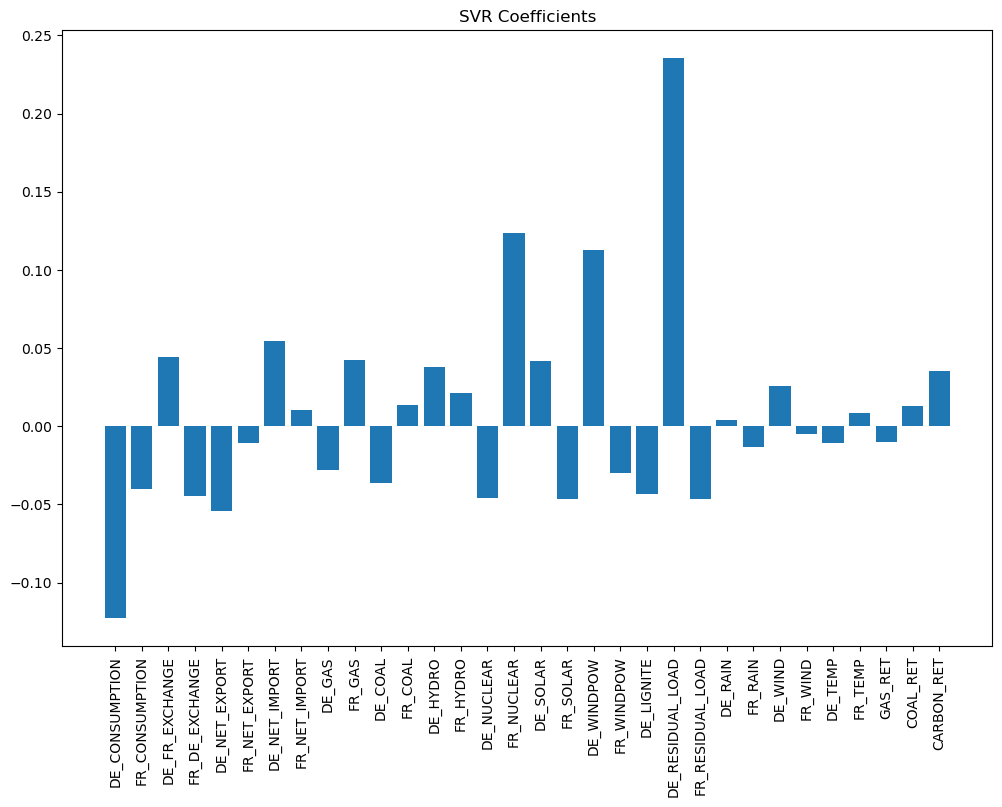

In [16]:
coefficients = svr.coef_.flatten()

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("SVR Coefficients")
plt.show()

### SVM with preprocessing

In [169]:
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor


X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

# Blank as tuning was done earlier
param_grid = {
    'simpleimputer': [KNNImputer()],
}


pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         SmartCorrelatedSelection(
                            variables=None,
                            method="pearson",
                            threshold=0.8,
                            missing_values="raise",
                            selection_method="variance",
                            estimator=None),
                         SVR(kernel="rbf", C=0.1, gamma='auto'),
                         )


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1, refit=True)
grid_search.fit(X_train, y_train.values.ravel())
y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))
print("CV Score:", grid_search.best_score_)

,TARGET,Predicted
TARGET,1.000000,-0.025379
Predicted,-0.025379,1.000000


CV Score: -1.057702832901796


## 4. XGboost

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Train the model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Predictions
preds = bst.predict(dtest)

find_metrics(y_test , preds)


Mean Squared Error: 1.3025608473088317
Root Mean Squared Error (RMSE): 1.1412978784300056
Mean Absolute Error (MAE): 0.9108024069948141
R-squared (R²): -0.24037068778683035
Mean Absolute Percentage Error (MAPE): 3.9337777735816646%


In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    eta = trial.suggest_float('eta', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    lambda_reg = trial.suggest_loguniform('lambda', 1e-8, 10.0)
    alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)

    params = {
        'max_depth': max_depth,
        'eta': eta,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambda_reg,
        'alpha': alpha,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    preds = bst.predict(dtest)
    
    cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=3,
                        early_stopping_rounds=10,
                        metrics="rmse", as_pandas=True, seed=11)
    

    bst = xgb.train(params, dtrain, num_boost_round=cv_results.shape[0])
    preds = bst.predict(dtest)
    error = mape_error(y_test, preds)
    return error


xgb_study = optuna.create_study(direction='minimize',
                            study_name="xgb_study",
                            storage='sqlite:///xgb_study.db',
                            load_if_exists=True)

xgb_study.optimize(objective_xgb, n_trials=1000 , n_jobs=-1)

print(f"Best trial: {xgb_study.best_trial}")
print(f"Best parameters: {xgb_study.best_params}")
print(f"Best value (accuracy): {xgb_study.best_value}")

/var/folders/9z/p9wc5ctx14z50221phyqkyz80000gn/T/ipykernel_95032/4071570254.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_reg = trial.suggest_loguniform('lambda', 1e-8, 10.0)
/var/folders/9z/p9wc5ctx14z50221phyqkyz80000gn/T/ipykernel_95032/4071570254.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0)
/var/folders/9z/p9wc5ctx14z50221phyqkyz80000gn/T/ipykernel_95032/4071570254.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_reg = tri

KeyboardInterrupt: 

## 5. Ensemble voting

In [17]:
from sklearn.ensemble import VotingRegressor

voting_ensemble = VotingRegressor([('rf', random_forest), ('lr', linear_regression), ('svr', svr)])
voting_ensemble.fit(X_train, y_train.values.ravel())

y_pred_voting = voting_ensemble.predict(X_test)
find_metrics(y_test , y_pred_voting)

Mean Squared Error: 1.0985799377430576
Root Mean Squared Error (RMSE): 1.0481316414186996
Mean Absolute Error (MAE): 0.8447968444470155
R-squared (R²): -0.04612875151473972
Mean Absolute Percentage Error (MAPE): 2.101581345046364%


In [18]:
from sklearn.ensemble import StackingRegressor

stacking_ensemble = StackingRegressor([('rf', random_forest), ('lr', linear_regression), ('svr', svr)],
                                      final_estimator=LinearRegression())
stacking_ensemble.fit(X_train, y_train.values.ravel())

y_pred_stacking = stacking_ensemble.predict(X_test)
find_metrics(y_test , y_pred_stacking)

Mean Squared Error: 1.1055083269008796
Root Mean Squared Error (RMSE): 1.051431560730835
Mean Absolute Error (MAE): 0.8460777358368019
R-squared (R²): -0.05272634796691156
Mean Absolute Percentage Error (MAPE): 1.8897367969789074%


## 6. Decision Tree ?

In [170]:
from sklearn.tree import DecisionTreeRegressor


X_train = pd.read_csv(path + 'X_train.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID').drop(columns=['COUNTRY' , 'DAY_ID'])
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')


param_grid = {
    'simpleimputer': [SimpleImputer(strategy='mean'), KNNImputer()],
    'decisiontreeregressor__max_depth': [2, 3, 4, 6, 10, 20],
    'decisiontreeregressor__min_samples_split': [10, 20, 50],
    'decisiontreeregressor__min_samples_leaf': [10, 20, 50]
}


pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                         SmartCorrelatedSelection(
                            variables=None,
                            method="pearson",
                            threshold=0.8,
                            missing_values="raise",
                            selection_method="variance",
                            estimator=None),
                         DecisionTreeRegressor(random_state=42),
                         )


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error",n_jobs=-1, refit=True)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

y_test["Predicted"] = grid_search.predict(X_test)
display(y_test.corr("spearman"))

Best Parameters: {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__min_samples_leaf': 50, 'decisiontreeregressor__min_samples_split': 10, 'simpleimputer': KNNImputer()}
Best Score: -1.0704141986928544


,TARGET,Predicted
TARGET,1.000000,-0.048953
Predicted,-0.048953,1.000000


#### One tree can be visualized

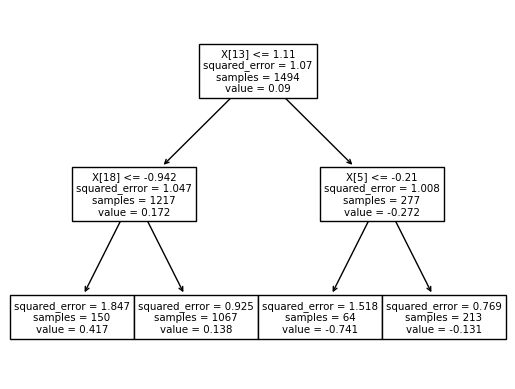

In [148]:
from sklearn import tree
_ = tree.plot_tree(grid_search.best_estimator_["decisiontreeregressor"])

In [149]:
scs_filtered_cols = [int(feature[1:]) for feature in grid_search.best_estimator_["smartcorrelatedselection"].features_to_drop_]
post_scs_cols = X_train.columns[[i for i in range(len(X_train.columns)) if i not in scs_filtered_cols]]
post_scs_cols[[5, 13, 18]]

Index(['FR_GAS', 'DE_WINDPOW', 'DE_RAIN'], dtype='object')